In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc

In [2]:
%%time
# Read Data

training_data_df = pd.read_csv('./prepped_data/training_data_ver_7(bdinfo_no_land).csv')
print(training_data_df.shape)
training_data_df.head()

(5141150, 51)
Wall time: 16.9 s


,지번주소,도로명주소,trade_type,전용면적(㎡),금액(만원),가격/면적,층,건물나이,target_log_transformed,target/area_log_transformed,특수지구분명,공시지가(만원),표준지여부,지목코드,토지면적_log,용도지역코드1,용도지역코드2,지형높이코드,지형형상코드,도로접면코드,year_linear,month_sin,month_cos,x_norm,y_norm,x_2nd,y_2nd,x*y,x_sin,y_sin,x_cos,y_cos,외필지_수,건축_면적(㎡),연면적(㎡),지상_층_수,지하_층_수,승용_승강기_수,비상용_승강기_수,부속_건축물_수,부속_건축물_면적(㎡),옥내_기계식_대수(대),옥외_기계식_대수(대),옥내_자주식_대수(대),옥외_자주식_대수(대),세대가구호_수,대장_구분_mapped,구조_mapped,주_용도_mapped,지붕_mapped,기타용도_주택종류_mapped
0,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,733.118971,2,25,10.950807,6.597308,1,921.0,0,8,7.063305,15,0,2,3,3,7.666667,-0.866025,-0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,1.0,528.17,5321.05,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,7.0
1,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,0,77.75,57000,733.118971,2,25,10.950807,6.597308,1,921.0,0,8,7.063305,15,0,2,3,3,7.916667,-0.500000,0.866025,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,1.0,528.17,5321.05,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,7.0
2,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,35000,450.160772,4,25,10.463103,6.109605,1,921.0,0,8,7.063305,15,0,2,3,3,7.000000,0.000000,1.000000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,1.0,528.17,5321.05,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,7.0
3,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,32000,411.575563,9,25,10.373491,6.019993,1,921.0,0,8,7.063305,15,0,2,3,3,7.166667,0.866025,0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,1.0,528.17,5321.05,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,7.0
4,서울특별시 강남구 개포동 655-2,서울특별시 강남구 언주로 103-0,1,77.75,37000,475.884244,1,25,10.518673,6.165175,1,921.0,0,8,7.063305,15,0,2,3,3,7.666667,-0.866025,-0.500000,5540.076032,-9058.615505,3.069244e+07,8.205851e+07,-5.018542e+07,-0.992492,0.986102,-0.122306,-0.166138,1.0,528.17,5321.05,9.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.0,0.0,0.0,0.0,0.0,7.0


In [3]:
cat_cols = ['trade_type', '특수지구분명', '표준지여부', '지목코드', '용도지역코드1', '용도지역코드2', '지형높이코드',
            '지형형상코드', '도로접면코드', '대장_구분_mapped', '구조_mapped', '주_용도_mapped', '지붕_mapped', '기타용도_주택종류_mapped'
           ]

In [4]:
test_data = training_data_df.drop(columns=['지번주소', '도로명주소']).sample(frac=0.2)
train_data = training_data_df.drop(columns=['지번주소', '도로명주소']).drop(test_data.index)
valid_data = train_data.sample(frac=0.2)
train_data = train_data.drop(valid_data.index)
print(test_data.shape)
print(valid_data.shape)
print(train_data.shape)

(1028230, 49)
(822584, 49)
(3290336, 49)


In [5]:
target_cols = ['금액(만원)', '가격/면적', 'target_log_transformed', 'target/area_log_transformed']#, 'land_area_log']

In [6]:
x_test = test_data.drop(columns=target_cols)
y_test = test_data['가격/면적']
print(x_test.shape)
print(y_test.shape)

(1028230, 45)
(1028230,)


In [7]:
x_valid = valid_data.drop(columns=target_cols)
y_valid = valid_data['가격/면적']
print(x_valid.shape)
print(y_valid.shape)

(822584, 45)
(822584,)


In [8]:
x_train = train_data.drop(columns=target_cols)
y_train = train_data['가격/면적']
print(x_train.shape)
print(y_train.shape)

(3290336, 45)
(3290336,)


<AxesSubplot:>

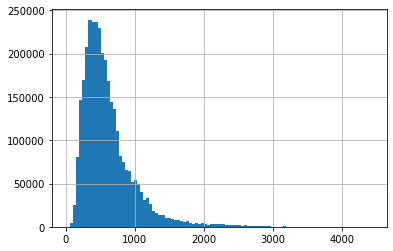

In [9]:
y_train.hist(bins=100)

# Training

In [10]:
from sklearn.metrics import r2_score

# ML Models

# Light GBM

In [11]:
import lightgbm as lgb

In [12]:
params = {
    'objective':'regression',
    'learning_rate': 0.03,
    'num_leaves': 31,
    'seed': 42,
    'max_depth': -1,
    'lambda_l2':0,
    'metric':'rmse'
}

In [13]:
train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
valid_dataset = lgb.Dataset(x_valid, label=y_valid, categorical_feature=cat_cols)

In [14]:
# without 토지면적 log
num_rounds = 500000

bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[valid_dataset], early_stopping_rounds=100, verbose_eval=50)

c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.124040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5276
[LightGBM] [Info] Number of data points in the train set: 3290336, number of used features: 45


c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
c:\users\max6296\ml\lib\site-packages\lightgbm\basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Info] Start training from score 614.179903
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 170.685
[100]	valid_0's rmse: 131.047
[150]	valid_0's rmse: 117.024
[200]	valid_0's rmse: 110.048
[250]	valid_0's rmse: 105.462
[300]	valid_0's rmse: 102.23
[350]	valid_0's rmse: 99.5325
[400]	valid_0's rmse: 97.3835
[450]	valid_0's rmse: 95.4476
[500]	valid_0's rmse: 93.8482
[550]	valid_0's rmse: 92.4162
[600]	valid_0's rmse: 91.1348
[650]	valid_0's rmse: 90.0645
[700]	valid_0's rmse: 89.034
[750]	valid_0's rmse: 88.1334
[800]	valid_0's rmse: 87.2585
[850]	valid_0's rmse: 86.4474
[900]	valid_0's rmse: 85.7261
[950]	valid_0's rmse: 85.053
[1000]	valid_0's rmse: 84.4071
[1050]	valid_0's rmse: 83.8168
[1100]	valid_0's rmse: 83.2183
[1150]	valid_0's rmse: 82.6773
[1200]	valid_0's rmse: 82.1424
[1250]	valid_0's rmse: 81.6577
[1300]	valid_0's rmse: 81.2185
[1350]	valid_0's rmse: 80.7791
[1400]	valid_0's rmse: 80.301
[1450]	valid_0's rmse: 79.9174
[1500]	v

[13050]	valid_0's rmse: 58.7358
[13100]	valid_0's rmse: 58.7064
[13150]	valid_0's rmse: 58.6821
[13200]	valid_0's rmse: 58.6584
[13250]	valid_0's rmse: 58.6311
[13300]	valid_0's rmse: 58.6064
[13350]	valid_0's rmse: 58.5752
[13400]	valid_0's rmse: 58.5502
[13450]	valid_0's rmse: 58.5218
[13500]	valid_0's rmse: 58.5002
[13550]	valid_0's rmse: 58.4703
[13600]	valid_0's rmse: 58.4416
[13650]	valid_0's rmse: 58.4109
[13700]	valid_0's rmse: 58.3826
[13750]	valid_0's rmse: 58.3538
[13800]	valid_0's rmse: 58.3335
[13850]	valid_0's rmse: 58.3128
[13900]	valid_0's rmse: 58.2897
[13950]	valid_0's rmse: 58.2658
[14000]	valid_0's rmse: 58.2404
[14050]	valid_0's rmse: 58.2177
[14100]	valid_0's rmse: 58.1914
[14150]	valid_0's rmse: 58.169
[14200]	valid_0's rmse: 58.149
[14250]	valid_0's rmse: 58.126
[14300]	valid_0's rmse: 58.1024
[14350]	valid_0's rmse: 58.0798
[14400]	valid_0's rmse: 58.0541
[14450]	valid_0's rmse: 58.0325
[14500]	valid_0's rmse: 58.0092
[14550]	valid_0's rmse: 57.9854
[14600]	val

[25900]	valid_0's rmse: 54.0924
[25950]	valid_0's rmse: 54.0806
[26000]	valid_0's rmse: 54.0701
[26050]	valid_0's rmse: 54.0591
[26100]	valid_0's rmse: 54.045
[26150]	valid_0's rmse: 54.0322
[26200]	valid_0's rmse: 54.0204
[26250]	valid_0's rmse: 54.0104
[26300]	valid_0's rmse: 53.9973
[26350]	valid_0's rmse: 53.9852
[26400]	valid_0's rmse: 53.9743
[26450]	valid_0's rmse: 53.9639
[26500]	valid_0's rmse: 53.953
[26550]	valid_0's rmse: 53.9424
[26600]	valid_0's rmse: 53.9327
[26650]	valid_0's rmse: 53.9226
[26700]	valid_0's rmse: 53.9115
[26750]	valid_0's rmse: 53.8988
[26800]	valid_0's rmse: 53.889
[26850]	valid_0's rmse: 53.8785
[26900]	valid_0's rmse: 53.8679
[26950]	valid_0's rmse: 53.8513
[27000]	valid_0's rmse: 53.8395
[27050]	valid_0's rmse: 53.8289
[27100]	valid_0's rmse: 53.8172
[27150]	valid_0's rmse: 53.8055
[27200]	valid_0's rmse: 53.7943
[27250]	valid_0's rmse: 53.781
[27300]	valid_0's rmse: 53.7673
[27350]	valid_0's rmse: 53.7578
[27400]	valid_0's rmse: 53.7491
[27450]	vali

[38750]	valid_0's rmse: 51.7839
[38800]	valid_0's rmse: 51.7785
[38850]	valid_0's rmse: 51.772
[38900]	valid_0's rmse: 51.7655
[38950]	valid_0's rmse: 51.7589
[39000]	valid_0's rmse: 51.7535
[39050]	valid_0's rmse: 51.747
[39100]	valid_0's rmse: 51.7405
[39150]	valid_0's rmse: 51.7319
[39200]	valid_0's rmse: 51.7259
[39250]	valid_0's rmse: 51.7185
[39300]	valid_0's rmse: 51.712
[39350]	valid_0's rmse: 51.7075
[39400]	valid_0's rmse: 51.7005
[39450]	valid_0's rmse: 51.6937
[39500]	valid_0's rmse: 51.6857
[39550]	valid_0's rmse: 51.6799
[39600]	valid_0's rmse: 51.6731
[39650]	valid_0's rmse: 51.6654
[39700]	valid_0's rmse: 51.6587
[39750]	valid_0's rmse: 51.6499
[39800]	valid_0's rmse: 51.6425
[39850]	valid_0's rmse: 51.6374
[39900]	valid_0's rmse: 51.6299
[39950]	valid_0's rmse: 51.6246
[40000]	valid_0's rmse: 51.6154
[40050]	valid_0's rmse: 51.6105
[40100]	valid_0's rmse: 51.6049
[40150]	valid_0's rmse: 51.5992
[40200]	valid_0's rmse: 51.593
[40250]	valid_0's rmse: 51.5875
[40300]	vali

[51650]	valid_0's rmse: 50.2635
[51700]	valid_0's rmse: 50.2599
[51750]	valid_0's rmse: 50.2567
[51800]	valid_0's rmse: 50.2521
[51850]	valid_0's rmse: 50.2484
[51900]	valid_0's rmse: 50.2443
[51950]	valid_0's rmse: 50.2401
[52000]	valid_0's rmse: 50.236
[52050]	valid_0's rmse: 50.232
[52100]	valid_0's rmse: 50.2273
[52150]	valid_0's rmse: 50.2243
[52200]	valid_0's rmse: 50.2206
[52250]	valid_0's rmse: 50.2174
[52300]	valid_0's rmse: 50.2138
[52350]	valid_0's rmse: 50.2089
[52400]	valid_0's rmse: 50.2024
[52450]	valid_0's rmse: 50.1974
[52500]	valid_0's rmse: 50.1923
[52550]	valid_0's rmse: 50.1875
[52600]	valid_0's rmse: 50.1829
[52650]	valid_0's rmse: 50.179
[52700]	valid_0's rmse: 50.1744
[52750]	valid_0's rmse: 50.1698
[52800]	valid_0's rmse: 50.1639
[52850]	valid_0's rmse: 50.1599
[52900]	valid_0's rmse: 50.1547
[52950]	valid_0's rmse: 50.15
[53000]	valid_0's rmse: 50.144
[53050]	valid_0's rmse: 50.1401
[53100]	valid_0's rmse: 50.136
[53150]	valid_0's rmse: 50.1309
[53200]	valid_0

[64550]	valid_0's rmse: 49.2066
[64600]	valid_0's rmse: 49.2008
[64650]	valid_0's rmse: 49.1972
[64700]	valid_0's rmse: 49.1925
[64750]	valid_0's rmse: 49.1886
[64800]	valid_0's rmse: 49.185
[64850]	valid_0's rmse: 49.1811
[64900]	valid_0's rmse: 49.1771
[64950]	valid_0's rmse: 49.173
[65000]	valid_0's rmse: 49.1706
[65050]	valid_0's rmse: 49.1676
[65100]	valid_0's rmse: 49.164
[65150]	valid_0's rmse: 49.1611
[65200]	valid_0's rmse: 49.1573
[65250]	valid_0's rmse: 49.1539
[65300]	valid_0's rmse: 49.1497
[65350]	valid_0's rmse: 49.1465
[65400]	valid_0's rmse: 49.1435
[65450]	valid_0's rmse: 49.1403
[65500]	valid_0's rmse: 49.1371
[65550]	valid_0's rmse: 49.1342
[65600]	valid_0's rmse: 49.1316
[65650]	valid_0's rmse: 49.1278
[65700]	valid_0's rmse: 49.1251
[65750]	valid_0's rmse: 49.1215
[65800]	valid_0's rmse: 49.1175
[65850]	valid_0's rmse: 49.1137
[65900]	valid_0's rmse: 49.1101
[65950]	valid_0's rmse: 49.1073
[66000]	valid_0's rmse: 49.1039
[66050]	valid_0's rmse: 49.1012
[66100]	val

[77400]	valid_0's rmse: 48.385
[77450]	valid_0's rmse: 48.3819
[77500]	valid_0's rmse: 48.3799
[77550]	valid_0's rmse: 48.3762
[77600]	valid_0's rmse: 48.3736
[77650]	valid_0's rmse: 48.3698
[77700]	valid_0's rmse: 48.3674
[77750]	valid_0's rmse: 48.3636
[77800]	valid_0's rmse: 48.3609
[77850]	valid_0's rmse: 48.358
[77900]	valid_0's rmse: 48.3558
[77950]	valid_0's rmse: 48.3533
[78000]	valid_0's rmse: 48.3511
[78050]	valid_0's rmse: 48.3477
[78100]	valid_0's rmse: 48.3437
[78150]	valid_0's rmse: 48.3399
[78200]	valid_0's rmse: 48.3368
[78250]	valid_0's rmse: 48.3334
[78300]	valid_0's rmse: 48.3302
[78350]	valid_0's rmse: 48.3267
[78400]	valid_0's rmse: 48.3238
[78450]	valid_0's rmse: 48.3213
[78500]	valid_0's rmse: 48.3189
[78550]	valid_0's rmse: 48.3165
[78600]	valid_0's rmse: 48.3139
[78650]	valid_0's rmse: 48.3117
[78700]	valid_0's rmse: 48.3086
[78750]	valid_0's rmse: 48.3059
[78800]	valid_0's rmse: 48.3028
[78850]	valid_0's rmse: 48.3005
[78900]	valid_0's rmse: 48.2979
[78950]	va

[90250]	valid_0's rmse: 47.7469
[90300]	valid_0's rmse: 47.7453
[90350]	valid_0's rmse: 47.7434
[90400]	valid_0's rmse: 47.7406
[90450]	valid_0's rmse: 47.7387
[90500]	valid_0's rmse: 47.7369
[90550]	valid_0's rmse: 47.735
[90600]	valid_0's rmse: 47.7333
[90650]	valid_0's rmse: 47.7311
[90700]	valid_0's rmse: 47.7287
[90750]	valid_0's rmse: 47.7261
[90800]	valid_0's rmse: 47.7246
[90850]	valid_0's rmse: 47.7226
[90900]	valid_0's rmse: 47.7204
[90950]	valid_0's rmse: 47.7174
[91000]	valid_0's rmse: 47.7156
[91050]	valid_0's rmse: 47.7135
[91100]	valid_0's rmse: 47.711
[91150]	valid_0's rmse: 47.7086
[91200]	valid_0's rmse: 47.7067
[91250]	valid_0's rmse: 47.7049
[91300]	valid_0's rmse: 47.7029
[91350]	valid_0's rmse: 47.7002
[91400]	valid_0's rmse: 47.6978
[91450]	valid_0's rmse: 47.6953
[91500]	valid_0's rmse: 47.6936
[91550]	valid_0's rmse: 47.6915
[91600]	valid_0's rmse: 47.6892
[91650]	valid_0's rmse: 47.6854
[91700]	valid_0's rmse: 47.6833
[91750]	valid_0's rmse: 47.6804
[91800]	va

KeyboardInterrupt: 

In [ ]:
lgb.plot_importance(bst)

In [ ]:
pred = bst.predict(x_test, num_iteration=bst.best_iteration)

In [ ]:
pd.DataFrame(y_test).to_csv('y_test_2021_01_03_22_11.csv', index=False)

In [ ]:
pd.DataFrame({'pred':pred}).to_csv('lgb_pred_2021_01_03_22_12.csv', index=False)

In [ ]:
r2_score(y_test, pred)

In [ ]:
compare_df = pd.DataFrame({'y_test':y_test, 'pred':pred})
print(compare_df.shape)
compare_df.head()

In [ ]:
compare_df.tail()

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, pred)

In [ ]:
from sklearn.metrics import mean_squared_log_error

In [ ]:
mean_squared_log_error(y_test, pred)

In [ ]:
pred_df = pd.DataFrame({'pred':pred})
print(pred_df.shape)
pred_df.head()

In [ ]:
negative_df = pred_df[pred_df['pred'] < 0]
print(negative_df.shape)

In [ ]:
negative_df

In [ ]:
y_test_df = pd.DataFrame({'y_test':y_test}).reset_index(drop=True)
print(y_test_df.shape)
y_test_df.head()

In [ ]:
y_test_df.loc[negative_df.index,:]

In [ ]:
col_map

In [ ]:
x_test.loc[y_test.iloc[negative_df.index].index,:]

# CatBoost

In [ ]:
from catboost import Pool, CatBoostRegressor

In [ ]:
train_pool = Pool(x_train, y_train, cat_features=cat_cols_mapped)
val_pool = Pool(x_valid, y_valid, cat_features=cat_cols_mapped)
test_pool = Pool(x_test, y_test, cat_features=cat_cols_mapped)

In [ ]:
model = CatBoostRegressor(task_type='GPU', iterations=100000, learning_rate=0.1)

In [ ]:
model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100)